In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

##Generate Train and Test Data

Let's assume we have some data for 50 time steps. 
We want a 50x2 time steps. The two columns represent the link costs to the two neighbors from $D_{B}$ and are the features we will train on. 

In [2]:
t = np.arange(0,50,1) #time vector

Since we don't have really have data from a simulation we will have to manually create it. We limit the link cost between 1 and 10. 

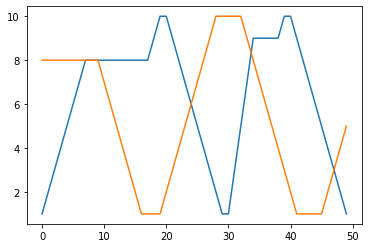

In [3]:
route1 = np.repeat(8, 9)
route2 = np.arange(1, 9, 1)

route2 = np.append(route2, np.repeat(8,9))
route2 = np.append(route2, np.arange(8,11,1))
route2 = np.append(route2, np.arange(10,0,-1))
route2 = np.append(route2, np.arange(1, 10, 2))
route2 = np.append(route2, np.repeat(9, 3))
route2 = np.append(route2, np.arange(9,11,1))
route2 = np.append(route2, np.arange(10,0,-1))
plt.plot(route2)

route1 = np.append(route1, np.arange(8,0,-1))
route1 = np.append(route1, np.repeat(1,2))
route1 = np.append(route1, np.arange(1,11, 1))
route1 = np.append(route1, np.repeat(10,3))
route1 = np.append(route1, np.arange(10,0,-1))
route1 = np.append(route1, np.repeat(1,3))
route1 = np.append(route1, np.arange(1,6,1))
plt.plot(route1)

In [4]:
route1=np.expand_dims(route1, axis=0)
route2=np.expand_dims(route2, axis=0)

x_train = np.concatenate((route1, route2), axis=0)
x_train = np.squeeze(x_train)
x_train.shape

(2, 50)

Now we need to generate the labels

(50, 2)
(50, 2)
(50, 2)


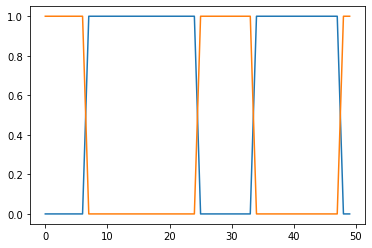

In [5]:
y_train = np.empty([50,2])
print(y_train.shape)
for i in range(50): 
    #Compare link cost. If link cost for route1 is less than route 2 then take route 1
    if route1[0][i] <= route2[0][i]: 
        y_train[i][0] = 1 
        y_train[i][1] = 0
    else: 
        y_train[i][0] = 0
        y_train[i][1] = 1

plt.plot(y_train)

print(y_train.shape)
x_train = np.transpose(x_train)
print(x_train.shape)

####Now we need to implement the windowing technique -- to do 

In [6]:
num_classes = 2
window_size = 4
input_size = 2
num_layers = 1
hidden_size = 5
seq_length = 2*window_size #
learning_rate = 0.01

In [7]:
l = 2*window_size+1
mat = np.empty([2,l])
mat.shape
#for i in range(1,l+1): 


(2, 9)

##NN Stuff

Hyperparameters

In [8]:
num_classes = 2
input_size = 2
num_layers = 1
hidden_size = 5
seq_length = 1
learning_rate = 0.01
batch_size = 5
epochs = 10 

Define the model 

In [16]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc =  nn.Linear(hidden_size, num_classes) 
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc(output) #Final Output
        out = self.sigmoid(out)
        return out

Create dataset and dataloaders 

In [10]:
#convert numpy data to tensor data for pytorch
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_train),
                                                torch.Tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            shuffle=True)

Train

In [17]:
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

#Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [19]:
n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (x, labels) in enumerate(train_loader):
        #x: -> (batch_size, seq, input_size)
        x = x.unsqueeze(1) 

        outputs = model(x)

        #outputs = outputs.type(torch.LongTensor)
        #labels = labels.type(torch.float)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Creating a test set

In [ ]:
x_test  = np.concatenate((route2, route1), axis=0)
x_test = np.squeeze(x_test)

y_test = np.empty([50,2])
for i in range(50): 
    #Compare link cost. If link cost for route1 is less than route 2 then take route 1
    if route1[0][i] <= route2[0][i]: 
        y_train[i][0] = 0 
        y_train[i][1] = 1
    else: 
        y_train[i][0] = 1
        y_train[i][1] = 0

plt.plot(y_train)

print(y_train.shape)
x_train = np.transpose(x_train)

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')